# Thesis Project

## Student: Tairbek Akhayev 551094

# EEG Classification with KAN and Baseline Models


## 1. Setup and Imports


In [1]:
import mne
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

## 2. Load and Explore EDF Files


Total EDF files: 28
Healthy files: 14
Patient files: 14
Extracting EDF parameters from /Users/tairakhayev/Desktop/ThesisProject/dataverse_files/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-06-23 16:14:37 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: DJZ>
>
Using matplotlib as 2D backend.


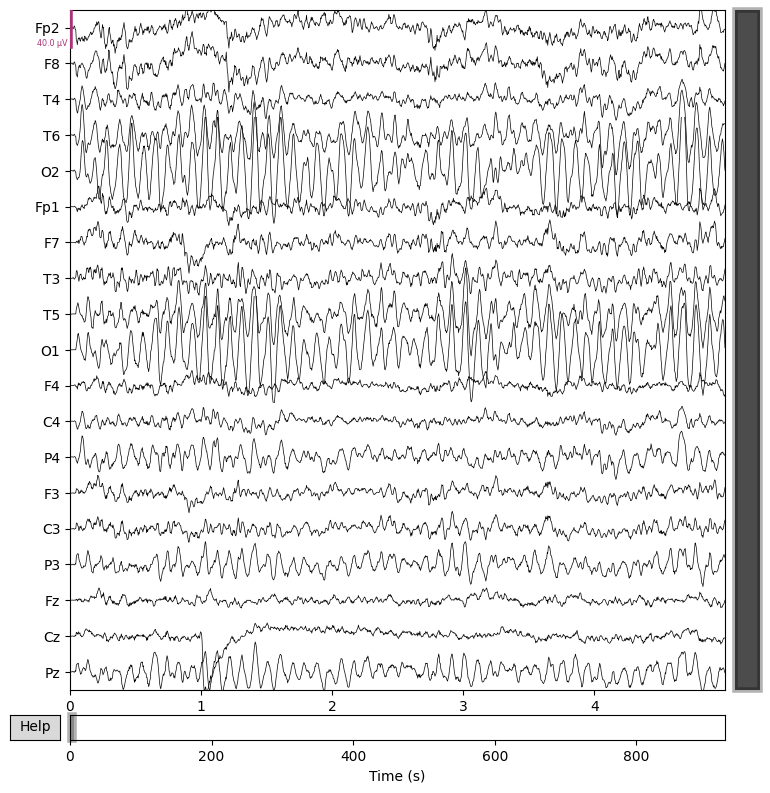

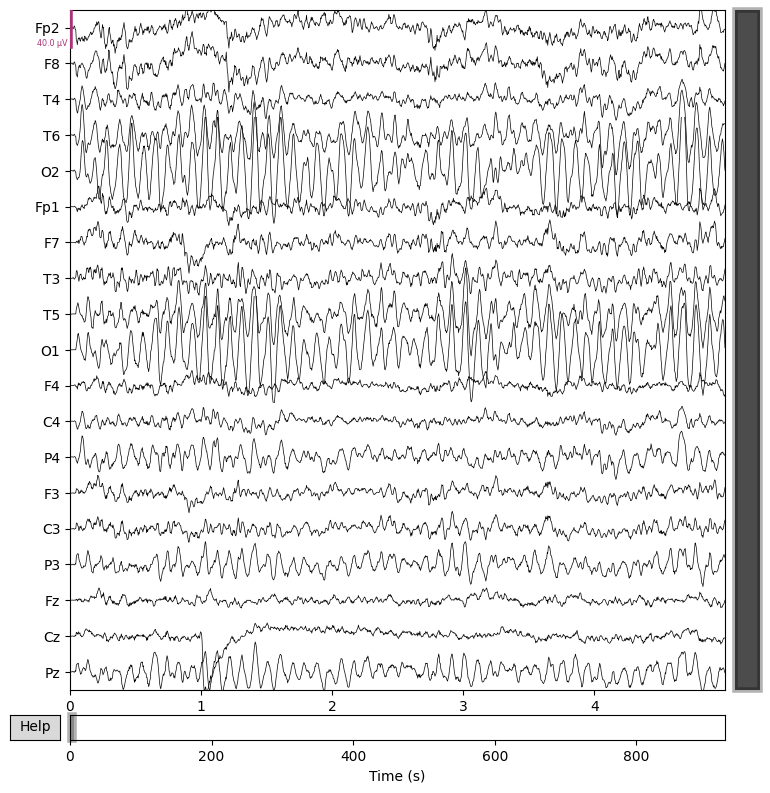

In [2]:
# Path to file
data_dir = "/Users/tairakhayev/Desktop/ThesisProject/dataverse_files"
all_files = glob(os.path.join(data_dir, "*.edf"))

print(f"Total EDF files: {len(all_files)}")

# Разделяем по имени файла (healthy = 'h', patient = 's')
healthy_files = [f for f in all_files if 'h' in os.path.basename(f)]
patient_files = [f for f in all_files if 's' in os.path.basename(f)]

print(f"Healthy files: {len(healthy_files)}")
print(f"Patient files: {len(patient_files)}")

# Check first file
sample_file = healthy_files[0]
raw = mne.io.read_raw_edf(sample_file, preload=True)

print(raw.info)
raw.plot(duration=5, n_channels=len(raw.ch_names))


In [3]:
# Inspect channel names in a few files (metadata only)
for fp in (healthy_files[:2] + patient_files[:1]):
    raw_hdr = mne.io.read_raw_edf(fp, preload=False, verbose=False)
    print(os.path.basename(fp), "->", raw_hdr.ch_names)


h01.edf -> ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
h14.edf -> ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
s01.edf -> ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']


In [4]:
from collections import Counter

chan_freq = Counter()
file_channels = []  # список наборов каналов по файлам

for fp in all_files:
    raw_hdr = mne.io.read_raw_edf(fp, preload=False, verbose=False)
    chs = [ch for ch in raw_hdr.ch_names if 'EEG' in raw_hdr.get_channel_types(picks=[ch])[0] or True]
    file_channels.append(set(chs))
    chan_freq.update(chs)

print("Total unique channels:", len(chan_freq))
print("Top-20 channels by presence:")
for ch, cnt in chan_freq.most_common(20):
    print(f"{ch}: in {cnt}/{len(all_files)} files")


Total unique channels: 19
Top-20 channels by presence:
Fp2: in 28/28 files
F8: in 28/28 files
T4: in 28/28 files
T6: in 28/28 files
O2: in 28/28 files
Fp1: in 28/28 files
F7: in 28/28 files
T3: in 28/28 files
T5: in 28/28 files
O1: in 28/28 files
F4: in 28/28 files
C4: in 28/28 files
P4: in 28/28 files
F3: in 28/28 files
C3: in 28/28 files
P3: in 28/28 files
Fz: in 28/28 files
Cz: in 28/28 files
Pz: in 28/28 files


## 3. Channel Selection 

## Step 3.1 — Define selected channels and a short summary


In [5]:
SELECTED_CHANNELS = [
    "Fp1", "Fp2",   # фронтальные полюса — когнитивный контроль, планирование
    "F3", "F4",     # дорсолатеральная префронтальная кора — подготовка движений
    "C3", "C4",     # моторная кора
    "T3", "T4",     # височные (аналог T7/T8) — сенсомоторная интеграция
    "Pz"            # теменно-срединная — сенсорная интеграция, внимание
]


In [6]:
import re

# --- Нормализация имён каналов и подготовка RAW ---
CANONICAL = {
    # частые алиасы → канонические 10-20
    "T7": "T3", "T8": "T4",
    "FT7": "T3", "FT8": "T4",  # на случай нестандартных разметок
}
VALID = set(SELECTED_CHANNELS)  # допустимые для проекта имена

## Step 3.4 — Plot selected channel positions


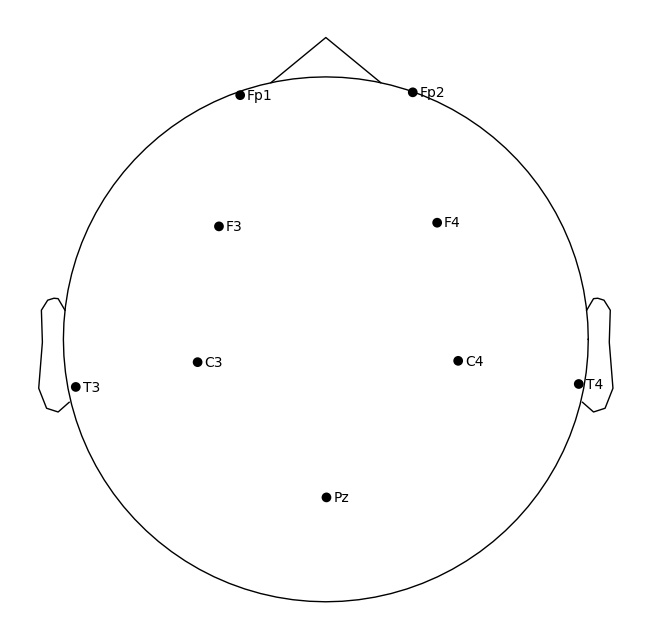

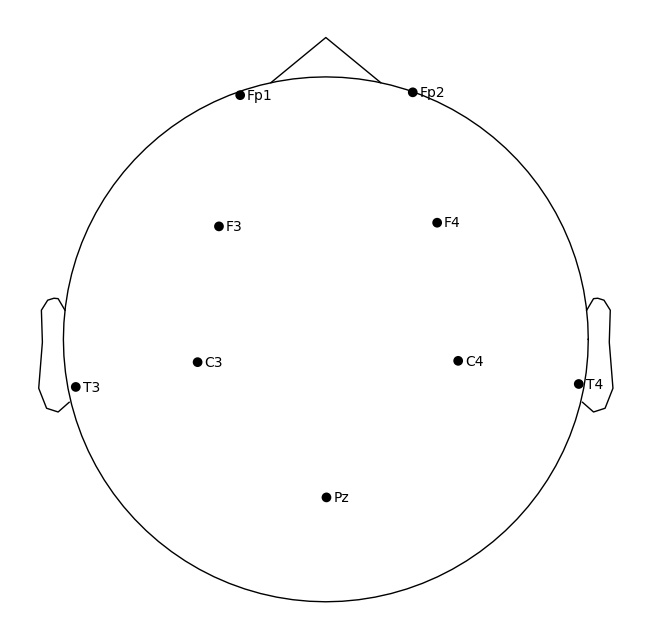

In [7]:
import mne

montage = mne.channels.make_standard_montage("standard_1020")
ch_pos_all = montage.get_positions()['ch_pos']

# Маппинг для визуализации (в стандартном 10-20 T7/T8)
viz_map = {"T3": "T7", "T4": "T8"}
viz_channels = [viz_map.get(ch, ch) for ch in SELECTED_CHANNELS]

sel_pos = {ch: ch_pos_all[vch] for ch, vch in zip(SELECTED_CHANNELS, viz_channels) if vch in ch_pos_all}

# Проверим, что все нашли
missing_viz = [ch for ch, vch in zip(SELECTED_CHANNELS, viz_channels) if vch not in ch_pos_all]
if missing_viz:
    print("Missing in standard_1020 (viz only):", missing_viz)

sel_montage = mne.channels.make_dig_montage(ch_pos=sel_pos, coord_frame='head')
mne.viz.plot_montage(sel_montage, show_names=True)


In [8]:
def _normalize_ch_name(name: str) -> str:
    """
    Приводит имя канала к каноническому виду:
    - убирает префиксы 'EEG ' и суффиксы типа '-REF', '-Ref', ' -M1'
    - оставляет только буквы/цифры/регистр как в 10-20
    - мапит T7/T8 → T3/T4 и т.п.
    """
    n = name.strip()
    n = re.sub(r'(?i)^EEG[\s\-_]*', '', n)          # убираем 'EEG '
    n = re.sub(r'(?i)[\s\-_]*(ref|m1|m2|avg|cz)$', '', n).strip()
    # берём первое «слово» типа Fp1, F3, C4, Pz и т.д.
    m = re.match(r'(?i)(Fp1|Fp2|Fz|F[3-8]|Cz|C[3-4]|T[3-6]|T7|T8|Pz|P[3-4]|O[1-2])', n)
    if m:
        n = m.group(1)
    # Приведём регистр корректно для Fp vs FP
    n = n.replace('fp', 'Fp').replace('FP', 'Fp')
    n = n.upper().replace('FP', 'Fp')  # Fp ок
    n = re.sub(r'([FCOP])Z$', r'\1z', n)   # вернуть строчное z для Fz/Cz/Pz/Oz
    # Маппинг алиасов
    n = CANONICAL.get(n, n)
    return n

In [9]:
def prepare_raw(fp: str, target_sfreq: float = 250.0, verbose: bool = False):
    """Читает EDF, оставляет только EEG, нормализует имена, приводит к общей частоте,
    применяет фильтры и average reference. Возвращает raw или None, если не хватает каналов."""
    raw = mne.io.read_raw_edf(fp, preload=True, verbose=verbose)
    raw.pick_types(eeg=True, meg=False, eog=False, ecg=False, stim=False, exclude=[])
    # нормализуем имена
    ch_renames = {ch: _normalize_ch_name(ch) for ch in raw.ch_names}
    raw.rename_channels(ch_renames)
    # возможно, после переименования остались дубликаты — удалим дубликаты, оставив первый
    seen = set()
    keep = []
    for ch in raw.ch_names:
        if ch in seen:
            continue
        seen.add(ch)
        keep.append(ch)
    raw.pick_channels(keep)

    # стандартный монтаж (если есть координаты — пропустит)
    try:
        raw.set_montage('standard_1020', on_missing='ignore')
    except Exception:
        pass

    # единая частота дискретизации
    if abs(raw.info['sfreq'] - target_sfreq) > 1e-3:
        raw.resample(target_sfreq, npad='auto')

    # фильтры (сначала полосовой, затем notch с гармоникой)
    raw.filter(l_freq=1., h_freq=45., fir_design='firwin', verbose=verbose)
    raw.notch_filter(freqs=[50., 100.], verbose=verbose)

    # average reference
    raw.set_eeg_reference('average', verbose=verbose)

    # проверяем наличие нужных каналов и упорядочиваем
    missing = [ch for ch in SELECTED_CHANNELS if ch not in raw.ch_names]
    if missing:
        if verbose:
            print(f"[SKIP] {os.path.basename(fp)} — отсутствуют каналы: {missing}")
        return None
    raw.pick_channels(SELECTED_CHANNELS)  # гарантированный порядок
    return raw

In [10]:
# Step 6.B — Windowing utility
def segment_windows(raw, window_sec=2, overlap=0.5):
    sfreq = raw.info['sfreq']
    n = int(window_sec * sfreq)          # длина окна (в сэмплах)
    step = max(1, int(n * (1 - overlap)))
    data = raw.get_data(picks='eeg')     # shape: [n_channels, T]
    n_ch, T = data.shape
    if T < n: 
        return np.empty((0, n_ch, n), dtype=data.dtype)
    starts = range(0, T - n + 1, step)
    windows = np.stack([data[:, s:s+n] for s in starts], axis=0)  # [n_win, n_ch, n]
    return windows


In [11]:
def windows_from_file(fp: str, window_sec=2.0, overlap=0.5, verbose=False):
    """Готовит raw и режет на окна. Возвращает np.ndarray [n_win, K, T] или None."""
    raw = prepare_raw(fp, verbose=verbose)
    if raw is None:
        return None
    wins = segment_windows(raw, window_sec=window_sec, overlap=overlap)
    return wins.astype(np.float32) if wins.size else None

## Step 3.3  Build dataset and save artifacts



In [12]:
# === Build dataset and save artifacts ===
save_dir = "/Users/tairakhayev/Desktop/ThesisProject/processed"

os.makedirs(save_dir, exist_ok=True)

X_chunks, y_list = [], []

def process_files(file_list, label):
    for fp in file_list:
        wins = windows_from_file(fp, window_sec=2.0, overlap=0.5, verbose=False)
        if wins is None or wins.size == 0:
            continue
        X_chunks.append(wins.astype(np.float32))
        y_list.extend([label] * len(wins))

# Healthy (label 0) and Parkinson (label 1)
process_files(healthy_files, 0)
process_files(patient_files, 1)

if not X_chunks:
    raise RuntimeError("No valid windows found — check channel mapping and data files.")

X = np.concatenate(X_chunks, axis=0)                  # [N, K, T]
y = np.array(y_list, dtype=np.int64)                  # [N]

# Sanity checks
assert X.ndim == 3, f"Expected X as [N,K,T], got {X.shape}"
assert X.shape[1] == len(SELECTED_CHANNELS), f"Channels mismatch: {X.shape[1]} vs {len(SELECTED_CHANNELS)}"

# Per‑channel normalization stats across all windows/time
norm_mean = X.mean(axis=(0, 2), keepdims=True).astype(np.float32)  # [1,K,1]
norm_std  = X.std(axis=(0, 2), keepdims=True).astype(np.float32)   # [1,K,1]
norm_std[norm_std < 1e-6] = 1e-6

# Save artifacts
np.save(os.path.join(save_dir, "X.npy"), X)
np.save(os.path.join(save_dir, "Y.npy"), y)
np.save(os.path.join(save_dir, "channels.npy"), np.array(SELECTED_CHANNELS, dtype=object))
np.save(os.path.join(save_dir, "norm_mean.npy"), norm_mean)
np.save(os.path.join(save_dir, "norm_std.npy"), norm_std)

print("Saved to:", save_dir)
print("X:", X.shape, X.dtype, "| y:", y.shape, y.dtype)
unique, counts = np.unique(y, return_counts=True)
print("Class balance:", dict(zip(unique.tolist(), counts.tolist())))

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code sh

## 8. Load and Split Data

- Load X and y from saved files
- Split into train (80%) and test (20%) sets
- Create PyTorch Dataset and DataLoader

In [13]:
## 8. Load and Split Data (X.npy / y.npy already normalized)

import os
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader

save_dir = "/Users/tairakhayev/Desktop/ThesisProject/processed"

# 1) Load normalized data + channels (for sanity checks)
X = np.load(os.path.join(save_dir, "X.npy"))          # already z-scored
y = np.load(os.path.join(save_dir, "Y.npy"))
SELECTED_CHANNELS = np.load(os.path.join(save_dir, "channels.npy"), allow_pickle=True).tolist()

print("Loaded:", X.shape, y.shape, "| K =", len(SELECTED_CHANNELS))

assert X.ndim == 3, f"Expected X as [N,K,T], got {X.shape}"
assert X.shape[1] == len(SELECTED_CHANNELS), "Channels mismatch with channels.npy"

# (Опционально) проверим, что нормстаты существуют — это сигнал, что X уже нормализован
pre_norm = os.path.exists(os.path.join(save_dir, "norm_mean.npy")) and \
           os.path.exists(os.path.join(save_dir, "norm_std.npy"))
print("Pre-normalized:", pre_norm)

# 2) Fresh train/test split (данные уже нормализованы общим train-статом из шага сохранения)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Test:",  X_test.shape,  y_test.shape)

# 3) Torch Dataset / DataLoader
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # [N,K,T]
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=batch_size, shuffle=True,num_workers=0)
test_loader  = DataLoader(EEGDataset(X_test,  y_test),  batch_size=batch_size, shuffle=False,num_workers=0)

print("DataLoaders ready. batch_size =", batch_size)


Loaded: (28835, 9, 500) (28835,) | K = 9
Pre-normalized: True
Train: (23068, 9, 500) (23068,)
Test: (5767, 9, 500) (5767,)
DataLoaders ready. batch_size = 64


## 9. KAN Model with PyTorch + PyKAN

Steps:
- Flatten EEG window (19×500 → 9500 features)
- Pass through Kolmogorov–Arnold Network (KAN)
- Output 2 classes (Healthy vs Parkinson)


In [14]:
from kan import KAN
import torch.nn as nn

K = X_train.shape[1]   # 9
T = X_train.shape[2]   # 500
POOL = 4               # 500 -> 125
hidden_units = [64, 32]
num_classes = 2

class LightKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.AvgPool1d(kernel_size=POOL, stride=POOL)  # [N,9,500]->[N,9,125]
        self.flatten = nn.Flatten()
        self.kan = KAN([K * (T // POOL)] + hidden_units + [num_classes])

    def forward(self, x):
        x = self.pool(x)
        x = self.flatten(x)
        return self.kan(x)

model = LightKAN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

checkpoint directory created: ./model
saving model version 0.0


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LightKAN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Using device:", device)


checkpoint directory created: ./model
saving model version 0.0
Using device: cpu


In [17]:
from tqdm.auto import tqdm  # важно: auto для ноутбуков/VS Code
import torch

def train_model(
    model,
    train_loader,
    test_loader,
    epochs=10,
    optimizer=None,
    criterion=None,
    device=None,
    show_progress=True
):
    # CPU по умолчанию
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model.to(device)
    criterion = criterion or torch.nn.CrossEntropyLoss()
    optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=1e-3)

    history = []
    for epoch in range(1, epochs + 1):
        # ---- Train ----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        it = tqdm(train_loader, total=len(train_loader),
                  desc=f"Epoch {epoch}/{epochs}", mininterval=0.5, leave=False) if show_progress else train_loader

        for inputs, labels in it:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

            if show_progress:
                it.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100.0*correct/max(1,total):.1f}%")

        train_acc = 100.0 * correct / max(1, total)
        avg_loss = running_loss / max(1, len(train_loader))

        # ---- Val ----
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, pred = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (pred == labels).sum().item()

        val_acc = 100.0 * val_correct / max(1, val_total)
        history.append({"epoch": epoch, "loss": avg_loss, "train_acc": train_acc, "val_acc": val_acc})

        print(f"Epoch {epoch}/{epochs} | Loss {avg_loss:.4f} | Train {train_acc:.2f}% | Val {val_acc:.2f}%")

    return history


In [18]:
history = train_model(model, train_loader, test_loader, epochs=10, optimizer=optimizer, criterion=criterion)

Using device: cpu


Epoch 1/10:   0%|          | 0/361 [00:00<?, ?it/s]

In [ ]:
from kan import KAN

try:
    model = KAN([9500, 256, 128, 2])  # твоя архитектура
    print("KAN initialized OK")
except Exception as e:
    print("Error:", e)


checkpoint directory created: ./model
saving model version 0.0
KAN initialized OK


In [ ]:
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# === 1. Проблема ===
print("Original data shape:", X_train.shape, X_test.shape)


Original data shape: (23068, 19, 500) (5767, 19, 500)


### "KAN crashed with 9500 features → applying PCA to reduce dimensionality

## Apllying PCA 


In [ ]:
n_components = 500  # уменьшаем 9500 → 500 признаков
pca = PCA(n_components=n_components)


In [ ]:
X_train_pca = pca.fit_transform(X_train.reshape(len(X_train), -1))
X_test_pca = pca.transform(X_test.reshape(len(X_test), -1))

print(f"After PCA: X_train shape = {X_train_pca.shape}, X_test shape = {X_test_pca.shape}")

After PCA: X_train shape = (23068, 500), X_test shape = (5767, 500)


In [ ]:
explained_var = np.sum(pca.explained_variance_ratio_) * 100
print(f"PCA completed: {n_components} features keep {explained_var:.2f}% of variance.")

print(f"New shapes: X_train={X_train_pca.shape}, X_test={X_test_pca.shape}")

PCA completed: 500 features keep 82.55% of variance.
New shapes: X_train=(23068, 500), X_test=(5767, 500)


## Preparing tensors 

In [ ]:
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Updating model for new size of entrance 

In [ ]:
input_size = n_components  # теперь вход = 500 признаков
hidden_units = [256, 128]
num_classes = 2


In [ ]:
# KAN модель
from kan import KAN
class KANClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.kan = KAN([input_size] + hidden_units + [num_classes])
    def forward(self, x):
        return self.kan(x)

model = KANClassifier()

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
train_model(model, train_loader, test_loader, epochs=10, lr=1e-3)

Python(89194) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 1/10:   9%|▉         | 16/181 [59:39<10:15:12, 223.71s/it]


KeyboardInterrupt: 